In [ ]:
import ROOT as r
import numpy as np
# import pandas as pd
# import pickle
# import sys
# from ShipGeoConfig import ConfigRegistry
from rootpyPickler import Unpickler
import shipLHC_conf as sndDet_conf
import SndlhcGeo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

Welcome to JupyROOT 6.26/10


In [1]:
import ROOT as r
import numpy as np
import pandas as pd
#import pickle
#import sys
#from ShipGeoConfig import ConfigRegistry
from rootpyPickler import Unpickler
import shipLHC_conf as sndDet_conf
import SndlhcGeo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from argparse import ArgumentParser
import time
from itertools import chain


# parser = ArgumentParser()

# parser.add_argument("--Z",   dest="z", required=False, default = 0, type = int)
# parser.add_argument("--E",   dest="e", required=False, default = 0, type = int)
# parser.add_argument("--N",   dest="n", required=False, default = 0, type = int)
# parser.add_argument("-o", "--output",dest="outputDir",  help="Output directory", required=False,  default=".")


options = [291,300,100]

# print(options.e,options.z)


def GetParticleCharge (pdgcode, pdgdatabase):

  #from PDG, get charge
    charge = 0.
    if (pdgdatabase.GetParticle(pdgcode)): 
        charge = pdgdatabase.GetParticle(pdgcode).Charge()
    elif (pdgcode > 1e+8):
        charge = 1. #these are heavy nuclei, for now we give them charge 1.Add a decode function with info from (https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
    return charge


def GetParticleName(pdgcode, pdgdatabase):

  #from PDG, get charge
    name = "zero"
    if (pdgdatabase.GetParticle(pdgcode)): 
        name = pdgdatabase.GetParticle(pdgcode).GetName()
    elif (pdgcode > 1e+8):
        name = "heavy nuclei" #these are heavy nuclei, for now we give them charge 1.Add a decode function with info from (https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
    return name


t1 = time.perf_counter()


scifi_x_avg = []
scifi_y_avg = []
scifi_z_avg = []

scifi_plane = []

vertical_hits = []

evt_idx = []


stat1_x_sipms = np.array([])
stat2_x_sipms = np.array([])
stat3_x_sipms = np.array([])
stat4_x_sipms = np.array([])
stat5_x_sipms = np.array([])

stat1_y_sipms = np.array([])
stat2_y_sipms = np.array([])
stat3_y_sipms = np.array([])
stat4_y_sipms = np.array([])
stat5_y_sipms = np.array([])
            

def get_QDC_US(hit):
    sig_left = 0; sig_right = 0

    # US or DS Muon Filter: save the QDC (NOT CALIBRATED as of 06.11.22)
    if hit.GetSystem() in [2, 3]:
        for ch in hit.GetAllSignals(False):
            if (hit.GetnSiPMs() > ch[0]):  # left side
                sig_left += ch[1]
            else:                           # right side
                sig_right += ch[1]
    
    return (sig_left, sig_right)

def MuFiGetStation(detID):
        return r.TMath.Floor(detID/1000)-r.TMath.Floor(detID/10000)*10

# define your functions/main here

from os.path import exists

cbmsim = r.TChain("cbmsim") # Create the TChain
cbmsim.SetBranchStatus("MCTrack", 0)

print("Starting chain")


n_files_to_read = 100
n_files_read = 0
for i in range(n_files_to_read) :
    file_name = '/eos/user/s/skatsaro/PGsim/depth_{}/pions_{}/Ntuples/{}/sndLHC.PG_211-TGeant4_digCPP.root'.format(options[0],options[1],i+1)
    
    # Combine the root files
    if not exists(file_name) :
        continue # Combine only existing root files
    this_read = cbmsim.Add(file_name)

    if this_read > 0 :
        n_files_read += 1
    
print(cbmsim.GetEntries()) # Check if all 1000 events were simulated and combined

pdg  = r.TDatabasePDG.Instance()

geofile = '/eos/user/s/skatsaro/PGsim/depth_{}/pions_{}/Ntuples/1/geofile_full.PG_211-TGeant4.root'.format(options[0],options[1])
fgeo    = r.TFile.Open(geofile)
upkl    = Unpickler(fgeo)
snd_geo = upkl.load('ShipGeo')
geo     = SndlhcGeo.GeoInterface(geofile)
run     = r.FairRunSim()
modules = sndDet_conf.configure(run, snd_geo)
r.gGeoManager.Import(geofile)
lsOfGlobals = r.gROOT.GetListOfGlobals()
lsOfGlobals.Add(geo.modules['Scifi'])
lsOfGlobals.Add(geo.modules['MuFilter'])
scifiDet    = lsOfGlobals.FindObject('Scifi')
muonfiltDet = lsOfGlobals.FindObject('MuFilter')

scifiDet.SetConfPar('Scifi/scifimat_length' , 39.0)
scifiDet.SetConfPar('Scifi/channel_width'   , (0.25/10))
scifiDet.SetConfPar('Scifi/epoxymat_z'      , 0.17)
scifiDet.SetConfPar('Scifi/nsipm_channels'  , 128)
scifiDet.SetConfPar('Scifi/nsipm_mat'       , 4)
scifiDet.SetConfPar('Scifi/nmats'           , 3)
scifiDet.SetConfPar('Scifi/sipm_edge'       , (0.17/10))
scifiDet.SetConfPar('Scifi/charr_width'     , (64 * 0.25/10))
scifiDet.SetConfPar('Scifi/charr_gap'       , (0.2/10))
scifiDet.SetConfPar('Scifi/sipm_diegap'     , (0.06/10))
scifiDet.SetConfPar('Scifi/firstChannelX'   , -19.528)
scifiDet.SiPMmapping()


# Loop over events
for i_event, event in enumerate(cbmsim) :
    if i_event % 100 == 0 :
        print("Reading event number {0}".format(i_event))

    # Truth-level information
#     mcTracks    = event.MCTrack
#     ScifiPoints = event.ScifiPoint
#     MuFilPoints = event.MuFilterPoint

    evt_vertical_hits = []
    
    scifi_left_x = []
    scifi_left_y = []
    scifi_left_z = []

    
    scifi_right_x = []
    scifi_right_y = []
    scifi_right_z = []


    # Digitised information
    ScifiDigihits = event.Digi_ScifiHits


    if (i_event%10)==0:
        print(i_event)


    # ... looping over digitised quantities

    if ScifiDigihits:
        for idxscifihits, scifihit in enumerate(ScifiDigihits):
            if scifihit.isValid():
                vLeft, vRight = r.TVector3(), r.TVector3()
                scifiDet.GetSiPMPosition(scifihit.GetDetectorID(), vLeft, vRight)
                stat_nr_scifi  = scifihit.GetStation()
                
                scifi_left_x.append(vLeft.X())
                scifi_left_y.append(vLeft.Y())
                scifi_left_z.append(vLeft.Z())
                
                
                scifi_right_x.append(vRight.X())
                scifi_right_y.append(vRight.Y())
                scifi_right_z.append(vRight.Z())

                scifi_plane.append(stat_nr_scifi)

                evt_vertical_hits.append(scifihit.isVertical())

                evt_idx.append(i_event)


        scifi_x_avg.append((np.array(scifi_left_x)+np.array(scifi_right_x))/2)
        scifi_y_avg.append((np.array(scifi_left_y)+np.array(scifi_right_y))/2)
        scifi_z_avg.append((np.array(scifi_left_z)+(scifi_right_z))/2)

        vertical_hits.append(evt_vertical_hits)
        
    a, b = r.TVector3(), r.TVector3()

    if i_event == 1:
        for i_sta in range(1,6):
            for i_mat in range(0,3):
                for i_sipm in range(0,4):
                    for i_chan in range(0, 128):

                        id = i_sta*1000000 + i_mat*10000 + i_sipm*1000 + i_chan

                        # Horizontal
                        scifiDet.GetSiPMPosition(id, a, b);

                        if i_sta == 1:
                            stat1_y_sipms = np.append(stat1_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 2:
                            stat2_y_sipms = np.append(stat2_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 3:
                            stat3_y_sipms = np.append(stat3_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 4:
                            stat4_y_sipms = np.append(stat4_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 5:
                            stat5_y_sipms = np.append(stat5_y_sipms,(a.Y() + b.Y())/2.)

                        # Vertical
                        id += 100000 
                        scifiDet.GetSiPMPosition(id, a, b)

                        if i_sta == 1:
                            stat1_x_sipms = np.append(stat1_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 2:
                            stat2_x_sipms = np.append(stat2_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 3:
                            stat3_x_sipms = np.append(stat3_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 4:
                            stat4_x_sipms = np.append(stat4_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 5:
                            stat5_x_sipms = np.append(stat5_x_sipms,(a.X() + b.X())/2.)
                            
                            
scifi_x_avg = np.array(list(chain.from_iterable(scifi_x_avg))) 
scifi_y_avg = np.array(list(chain.from_iterable(scifi_y_avg)))
scifi_z_avg = np.array(list(chain.from_iterable(scifi_z_avg)))

vertical_hits = np.array(list(chain.from_iterable(vertical_hits)))

scifi_plane = np.array(scifi_plane)
evt_idx = np.array(evt_idx)

# np.savetxt("{}scifi_plane.txt".format(options.outputDir), scifi_plane, delimiter=',')
# np.savetxt("{}evt_idx.txt".format(options.outputDir), evt_idx, delimiter=',')
# np.savetxt("{}vertical_hits.txt".format(options.outputDir), vertical_hits, delimiter=',')

                
for plane, sipm_counts in enumerate([stat1_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    # stat_x_hits = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101))
    # np.savetxt("{}hits_x_{}.txt".format(options.outputDir,plane), stat_x_hits[0], delimiter=',')
    
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    
    # np.savetxt("{}hits_x_{}.txt".format(options.outputDir,plane), stat_x_scaled[0], delimiter=',')
    
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))
    
    # np.savetxt("{}SiPM_x_{}.txt".format(options.outputDir,plane), stat_x_sipm_counts[0], delimiter=',')
    
    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)
#     np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')

Welcome to JupyROOT 6.26/10
Starting chain
1000
using geofile: /eos/user/s/skatsaro/PGsim/depth_291/pions_300/Ntuples/1/geofile_full.PG_211-TGeant4.root
Reading event number 0
0
10
20
30
40
50
60
70
80
90
Reading event number 100
100
110
120
130
140
150
160
170
180
190
Reading event number 200
200
210
220
230
240
250
260
270
280
290
Reading event number 300
300
310
320
330
340
350
360
370
380
390
Reading event number 400
400
410
420
430
440
450
460
470
480
490
Reading event number 500
500
510
520
530
540
550
560
570
580
590
Reading event number 600
600
610
620
630
640
650
660
670
680
690
Reading event number 700
700
710
720
730
740
750
760
770
780
790
Reading event number 800
800
810
820
830
840
850
860
870
880
890
Reading event number 900
900
910
920
930
940
950
960
970
980
990


<ipython-input-1-8de16aed9f64>:281: RuntimeWarning: invalid value encountered in divide
  PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)


In [2]:
def GetParticleCharge (pdgcode, pdgdatabase):

  #from PDG, get charge
    charge = 0.
    if (pdgdatabase.GetParticle(pdgcode)): 
        charge = pdgdatabase.GetParticle(pdgcode).Charge()
    elif (pdgcode > 1e+8):
        charge = 1. #these are heavy nuclei, for now we give them charge 1.Add a decode function with info from (https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
    return charge

In [3]:
def GetParticleName(pdgcode, pdgdatabase):

  #from PDG, get charge
    name = "zero"
    if (pdgdatabase.GetParticle(pdgcode)): 
        name = pdgdatabase.GetParticle(pdgcode).GetName()
    elif (pdgcode > 1e+8):
        name = "heavy nuclei" #these are heavy nuclei, for now we give them charge 1.Add a decode function with info from (https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
    return name

In [4]:
t1 = time.perf_counter()
scifi_x_avg = []
scifi_y_avg = []
scifi_z_avg = []

scifi_plane = []

vertical_hits = []

evt_idx = []

# particle_name = np.array([])

stat1_x_sipms = np.array([])
stat2_x_sipms = np.array([])
stat3_x_sipms = np.array([])
stat4_x_sipms = np.array([])
stat5_x_sipms = np.array([])

stat1_y_sipms = np.array([])
stat2_y_sipms = np.array([])
stat3_y_sipms = np.array([])
stat4_y_sipms = np.array([])
stat5_y_sipms = np.array([])

            

def get_QDC_US(hit):
    sig_left = 0; sig_right = 0

    # US or DS Muon Filter: save the QDC (NOT CALIBRATED as of 06.11.22)
    if hit.GetSystem() in [2, 3]:
        for ch in hit.GetAllSignals(False):
            if (hit.GetnSiPMs() > ch[0]):  # left side
                sig_left += ch[1]
            else:                           # right side
                sig_right += ch[1]
    
    return (sig_left, sig_right)

def MuFiGetStation(detID):
        return r.TMath.Floor(detID/1000)-r.TMath.Floor(detID/10000)*10

# define your functions/main here

from os.path import exists

cbmsim = r.TChain("cbmsim") # Create the TChain

# cbmsim.SetBranchStatus("*", 0)
# cbmsim.SetBranchStatus("Digi_ScifiHits", 1)
# cbmsim.SetBranchStatus()
cbmsim.SetBranchStatus("MCTrack", 0)
print("Starting chain")

n_files_to_read = 100
n_files_read = 0
for i in range(n_files_to_read) :
    file_name = '/eos/user/s/skatsaro/PGsim/depth_291/pions_300/Ntuples/{}/sndLHC.PG_211-TGeant4_digCPP.root'.format(i+1)
    
    # Combine the root files
    if not exists(file_name) :
        continue # Combine only existing root files
    this_read = cbmsim.Add(file_name)

    if this_read > 0 :
        n_files_read += 1
    
print(cbmsim.GetEntries()) # Check if all 1000 events were simulated and combined

pdg  = r.TDatabasePDG.Instance()


geofile = '/eos/user/s/skatsaro/PGsim/depth_291/pions_300/Ntuples/1/geofile_full.PG_211-TGeant4.root'
# geofile = '/eos/experiment/sndlhc/users/marssnd/PGsim/pion_5GeV/geofile_full.PG_211-TGeant4.root'
fgeo    = r.TFile.Open(geofile)
upkl    = Unpickler(fgeo)
snd_geo = upkl.load('ShipGeo')
geo     = SndlhcGeo.GeoInterface(geofile)
run     = r.FairRunSim()
modules = sndDet_conf.configure(run, snd_geo)
r.gGeoManager.Import(geofile)
lsOfGlobals = r.gROOT.GetListOfGlobals()
lsOfGlobals.Add(geo.modules['Scifi'])
# lsOfGlobals.Add(geo.modules['MuFilter'])
scifiDet    = lsOfGlobals.FindObject('Scifi')
# muonfiltDet = lsOfGlobals.FindObject('MuFilter')

scifiDet.SetConfPar('Scifi/scifimat_length' , 39.0)
scifiDet.SetConfPar('Scifi/channel_width'   , (0.25/10))
scifiDet.SetConfPar('Scifi/epoxymat_z'      , 0.17)
scifiDet.SetConfPar('Scifi/nsipm_channels'  , 128)
scifiDet.SetConfPar('Scifi/nsipm_mat'       , 4)
scifiDet.SetConfPar('Scifi/nmats'           , 3)
scifiDet.SetConfPar('Scifi/sipm_edge'       , (0.17/10))
scifiDet.SetConfPar('Scifi/charr_width'     , (64 * 0.25/10))
scifiDet.SetConfPar('Scifi/charr_gap'       , (0.2/10))
scifiDet.SetConfPar('Scifi/sipm_diegap'     , (0.06/10))
scifiDet.SetConfPar('Scifi/firstChannelX'   , -19.528)
scifiDet.SiPMmapping()


# Loop over events
for i_event, event in enumerate(cbmsim) :
    if i_event % 100 == 0 :
        print("Reading event number {0}".format(i_event))

    # Truth-level information
#     mcTracks    = event.MCTrack
#     ScifiPoints = event.ScifiPoint
#     MuFilPoints = event.MuFilterPoint

    evt_vertical_hits = []

#     scifi_left_x = np.array([])
#     scifi_left_y = np.array([])
#     scifi_left_z = np.array([])
    
    scifi_left_x = []
    scifi_left_y = []
    scifi_left_z = []


#     scifi_right_x = np.array([])
#     scifi_right_y = np.array([])
#     scifi_right_z = np.array([])
    
    scifi_right_x = []
    scifi_right_y = []
    scifi_right_z = []


    # Digitised information
    ScifiDigihits = event.Digi_ScifiHits


    if (i_event%10)==0:
        print(i_event)


    # ... looping over digitised quantities

    if ScifiDigihits:
        for idxscifihits, scifihit in enumerate(ScifiDigihits):
            if scifihit.isValid():
#                 print(idxscifihits)
                vLeft, vRight = r.TVector3(), r.TVector3()
                scifiDet.GetSiPMPosition(scifihit.GetDetectorID(), vLeft, vRight)
                stat_nr_scifi  = scifihit.GetStation()

#                 scifi_left_x = np.append(scifi_left_x,vLeft.X())
#                 scifi_left_y = np.append(scifi_left_y,vLeft.Y())
#                 scifi_left_z = np.append(scifi_left_z,vLeft.Z())
                
                scifi_left_x.append(vLeft.X())
                scifi_left_y.append(vLeft.Y())
                scifi_left_z.append(vLeft.Z())


#                 scifi_right_x = np.append(scifi_right_x,vRight.X())
#                 scifi_right_y = np.append(scifi_right_y,vRight.Y())
#                 scifi_right_z = np.append(scifi_right_z,vRight.Z())
                
                
                scifi_right_x.append(vRight.X())
                scifi_right_y.append(vRight.Y())
                scifi_right_z.append(vRight.Z())

                scifi_plane.append(stat_nr_scifi)

                evt_vertical_hits.append(scifihit.isVertical())

                evt_idx.append(i_event)
                
#                 if stat_nr_scifi == 1 and scifihit.isVertical()==1:
#                         stat1_hits.Fill((vLeft.X() + vRight.X())/2.)


        scifi_x_avg.append((np.array(scifi_left_x)+np.array(scifi_right_x))/2)
        scifi_y_avg.append((np.array(scifi_left_y)+np.array(scifi_right_y))/2)
        scifi_z_avg.append((np.array(scifi_left_z)+np.array(scifi_right_z))/2)

#         scifi_evt_x_avg = (scifi_left_x+scifi_right_x)/2
#         scifi_evt_y_avg = (scifi_left_y+scifi_right_y)/2
#         scifi_evt_z_avg = (scifi_left_z+scifi_right_z)/2

        vertical_hits.append(evt_vertical_hits)
        
    a, b = r.TVector3(), r.TVector3()

    if i_event == 1:
        for i_sta in range(1,6):
            for i_mat in range(0,3):
                for i_sipm in range(0,4):
                    for i_chan in range(0, 128):

                        id = i_sta*1000000 + i_mat*10000 + i_sipm*1000 + i_chan

                        # Horizontal
                        scifiDet.GetSiPMPosition(id, a, b);
#                         h_hor.Fill((a.Z() + b.Z())/2., (a.Y() + b.Y())/2.)

                        if i_sta == 1:
                            stat1_y_sipms = np.append(stat1_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 2:
                            stat2_y_sipms = np.append(stat2_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 3:
                            stat3_y_sipms = np.append(stat3_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 4:
                            stat4_y_sipms = np.append(stat4_y_sipms,(a.Y() + b.Y())/2.)
                        if i_sta == 5:
                            stat5_y_sipms = np.append(stat5_y_sipms,(a.Y() + b.Y())/2.)

                        # Vertical
                        id += 100000 
                        scifiDet.GetSiPMPosition(id, a, b)
#                         h_ver.Fill((a.Z() + b.Z())/2., (a.X() + b.X())/2.)

                        if i_sta == 1:
                            stat1_x_sipms = np.append(stat1_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 2:
                            stat2_x_sipms = np.append(stat2_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 3:
                            stat3_x_sipms = np.append(stat3_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 4:
                            stat4_x_sipms = np.append(stat4_x_sipms,(a.X() + b.X())/2.)
                        if i_sta == 5:
                            stat5_x_sipms = np.append(stat5_x_sipms,(a.X() + b.X())/2.)
                
from itertools import chain
# newlist = list(chain.from_iterable(newlist))                        
# list(numpy.array(a).flat)
scifi_x_avg = np.array(list(chain.from_iterable(scifi_x_avg))) 
scifi_y_avg = np.array(list(chain.from_iterable(scifi_y_avg)))
scifi_z_avg = np.array(list(chain.from_iterable(scifi_z_avg)))

scifi_plane = np.array(scifi_plane)

vertical_hits = np.array(list(chain.from_iterable(vertical_hits)))

evt_idx = np.array(evt_idx)



#     if np.unique(evt_vertical_hits).size==2:


#         vert = evt_vertical_hits == 1
#         horz = evt_vertical_hits == 0


#         event_avg_x = np.append(event_avg_x,np.average(scifi_evt_x_avg[vert]))
#         event_avg_y = np.append(event_avg_y,np.average(scifi_evt_y_avg[horz]))
#         print(scifi_evt_x_avg[vert].shape,scifi_evt_y_avg[horz].shape,np.average(scifi_evt_x_avg[evt_vertical_hits==1]),\
#               np.average(scifi_evt_y_avg[evt_vertical_hits==0]))

t2 = time.perf_counter()
print(t2-t1)

Starting chain
1000
using geofile: /eos/user/s/skatsaro/PGsim/depth_291/pions_300/Ntuples/1/geofile_full.PG_211-TGeant4.root
Reading event number 0
0
10
20
30
40
50
60
70
80
90
Reading event number 100
100
110
120
130
140
150
160
170
180
190
Reading event number 200
200
210
220
230
240
250
260
270
280
290
Reading event number 300
300
310
320
330
340
350
360
370
380
390
Reading event number 400
400
410
420
430
440
450
460
470
480
490
Reading event number 500
500
510
520
530
540
550
560
570
580
590
Reading event number 600
600
610
620
630
640
650
660
670
680
690
Reading event number 700
700
710
720
730
740
750
760
770
780
790
Reading event number 800
800
810
820
830
840
850
860
870
880
890
Reading event number 900
900
910
920
930
940
950
960
970
980
990
38.043540827929974
[INFO] Media file used: /eos/user/s/skatsaro/sw/slc7_x86-64/sndsw/master-local1/geometry/media.geo


Info in <TGeoManager::CloseGeometry>: Geometry loaded from file...
Info in <TGeoManager::SetTopVolume>: Top volume is cave. Master volume is cave
Info in <TGeoNavigator::BuildCache>: --- Maximum geometry depth set to 100
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CountLevels>: max level = 7, max placements = 2829
Info in <TGeoManager::CloseGeometry>: 342536 nodes/ 81 volume UID's in FAIR geometry
Info in <TGeoManager::CloseGeometry>: ----------------modeler ready----------------
Info in <TGeoManager::Import>: Reading geometry from file: /eos/user/s/skatsaro/PGsim/depth_291/pions_300/Ntuples/1/geofile_full.PG_211-TGeant4.root
Info in <TGeoManager::CloseGeometry>: Geometry loaded from file...
Info in <TGeoManager::SetTopVolume>: Top volume is cave. Master volume is cave
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CountLevels>: max level = 7, max placements = 2829
Info in <TGeoManager::CloseGeometry>: 342536 nodes/ 81 volume UID's in FAIR

In [ ]:
for plane, sipm_counts in enumerate([stat1_x_sipms,stat2_x_sipms,stat3_x_sipms,stat4_x_sipms,stat5_x_sipms],start=1):
    evt = np.where(evt_idx==0)[0]
    plane_idx = np.where(scifi_plane==plane)[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101))
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))

    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)
    np.savetxt("{}PDF_x_{}_1.txt".format(options.outputDir,plane), PDF, delimiter=',')
#     plt.show()

In [ ]:
for plane, sipm_counts in enumerate([stat1_x_sipms,stat2_x_sipms,stat3_x_sipms,stat4_x_sipms,stat5_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))

    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)

    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
    np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')
#     plt.show()

In [ ]:
for plane, sipm_counts in enumerate([stat1_x_sipms,stat2_x_sipms,stat3_x_sipms,stat4_x_sipms,stat5_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))

    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)

    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
    np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')
#     plt.show()

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for depth in [291,295,304,308]:
    PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_x_2.txt".format(depth))
    plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF,histtype="step",
                        label=[str(depth)+" cm"])

plt.xlabel("x [cm]")
plt.ylabel("PDF")
plt.title("Station2_x")
plt.legend(title="Z position")

plt.savefig("station2_x_depths.png")
plt.show()

In [5]:
parser = ArgumentParser()
group = parser.add_mutually_exclusive_group()

parser.add_argument("--Z",   dest="z", required=False, default = 0, type = int)
parser.add_argument("--E",   dest="e", required=False, default = 0, type = int)
parser.add_argument("--Ntuple",  dest="ntuple",  help="Use ntuple as input", required=False, action="store_true")
parser.add_argument("--MuonBack",dest="muonback",  help="Generate events from muon background file, --Cosmics=0 for cosmic generator data", required=False, action="store_true")
parser.add_argument("--Pythia8", dest="pythia8", help="Use Pythia8", required=False, action="store_true")
parser.add_argument("--PG",      dest="pg",      help="Use Particle Gun", required=False, action="store_true")
parser.add_argument("--pID",     dest="pID",     help="id of particle used by the gun (default=22)", required=False, default=22, type=int)
parser.add_argument("--Estart",  dest="Estart",  help="start of energy range of particle gun for muflux detector (default=10 GeV)", required=False, default=10, type=float)
parser.add_argument("--Eend",    dest="Eend",    help="end of energy range of particle gun for muflux detector (default=10 GeV)", required=False, default=10, type=float)
parser.add_argument("--EVx",    dest="EVx",    help="particle gun xpos", required=False, default=0, type=float)

options = parser.parse_args()

options.

SyntaxError: invalid syntax (<ipython-input-5-8ca65a879091>, line 17)

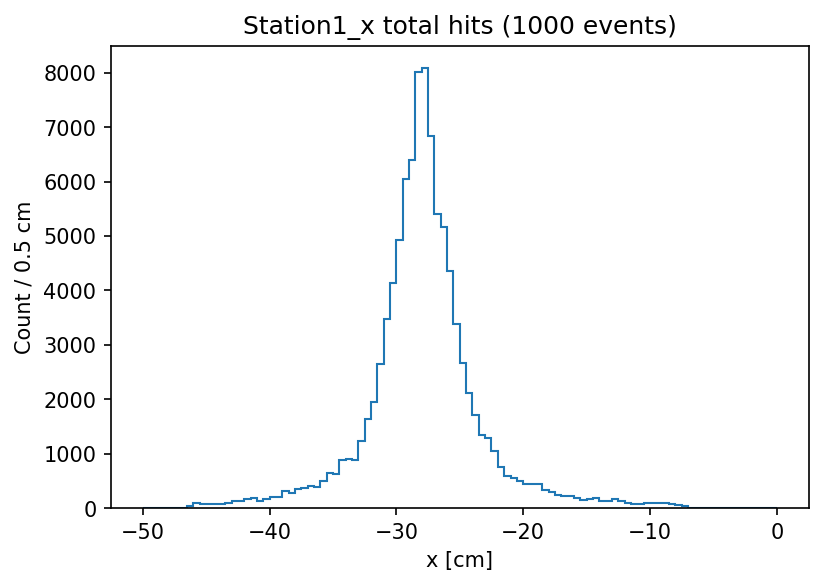

In [2]:
plane_idx = np.where(scifi_plane==1)[0]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
    
plt.hist(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),histtype="step")

plt.xlabel("x [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Station1_x total hits (1000 events)")
# plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
# plt.savefig('scifi x avg (overlayed).png')
# plt.savefig("station1 x total hits (1000 events).png")

plt.show()

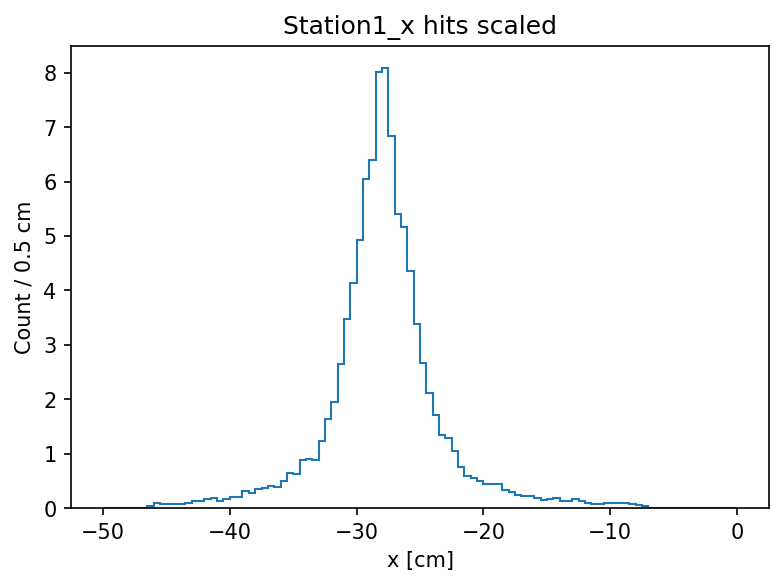

In [3]:
plane_idx = np.where(scifi_plane==1)[0]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
stat1_x_scaled = plt.hist(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),histtype="step",
         weights=np.ones(x_size)/1000)

plt.xlabel("x [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Station1_x hits scaled")
# plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
plt.savefig("station1 x hits scaled.png")
#     plt.savefig('scifi x avg. (plane {}).png'.format(plane))

plt.show()

In [4]:
simps_x = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_x_{}.txt".format(station))
    simps_x.append(data)

<ipython-input-8-f25671229d2b>:3: RuntimeWarning: invalid value encountered in divide
  pdf = plt.hist(np.linspace(-49.75,-0.25,100),bins = np.linspace(-50,0,101), weights=np.nan_to_num(stat1_x_scaled[0]/simps_x[0],0),histtype="step")


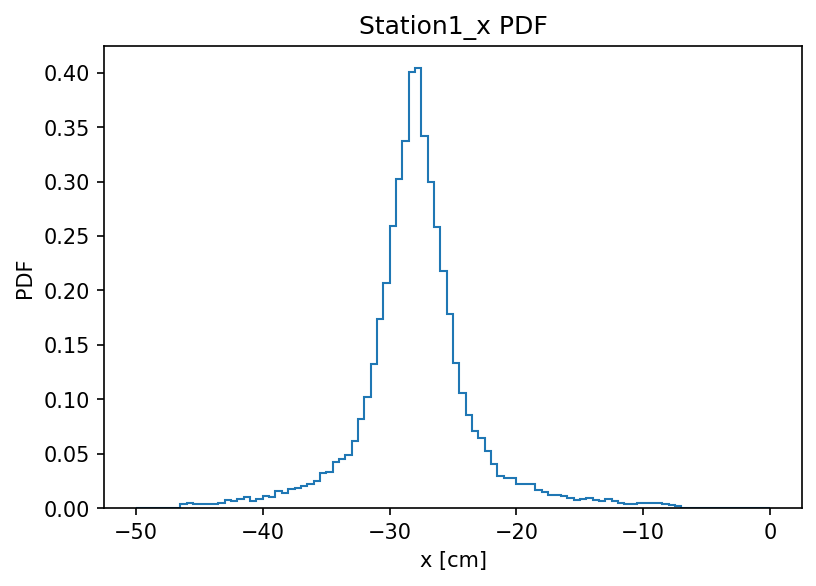

In [8]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

pdf = plt.hist(np.linspace(-49.75,-0.25,100),bins = np.linspace(-50,0,101), weights=np.nan_to_num(stat1_x_scaled[0]/simps_x[0],0),histtype="step")

plt.title("Station1_x PDF")
plt.ylabel("PDF")
plt.xlabel("x [cm]")
plt.savefig("station1 x PDF.png")
plt.show()

In [10]:
pdfs = []
for plane, sipm_counts in enumerate([stat1_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    # stat_x_hits = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101))
    # np.savetxt("{}hits_x_{}.txt".format(options.outputDir,plane), stat_x_hits[0], delimiter=',')
    
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    
    # np.savetxt("{}hits_x_{}.txt".format(options.outputDir,plane), stat_x_scaled[0], delimiter=',')
    
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))
    
    # np.savetxt("{}SiPM_x_{}.txt".format(options.outputDir,plane), stat_x_sipm_counts[0], delimiter=',')
    
    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)
    pdfs.append(PDF)
#     np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')

<ipython-input-10-8d4df1528c1d>:18: RuntimeWarning: invalid value encountered in divide
  PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)


In [17]:
stat_x_scaled = plt.hist(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==plane],bins = np.linspace(-50,-0,101),
                             histtype="step", weights=np.ones(x_size)/(n_files_to_read*10))

In [ ]:
for plane, sipm_counts in enumerate([stat1_x_sipms,stat2_x_sipms,stat3_x_sipms,stat4_x_sipms,stat5_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))

    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)

    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
    np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')
#     plt.show()

In [ ]:
for plane, sipm_counts in enumerate([stat1_y_sipms,stat2_y_sipms,stat3_y_sipms,stat4_y_sipms,stat5_y_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    y_size = np.shape(scifi_y_avg[plane_idx][vertical_hits[plane_idx]==0])[0]
    stat_y_scaled = np.histogram(scifi_y_avg[plane_idx][vertical_hits[plane_idx]==0],bins = np.linspace(10,60,101),
                             weights=np.ones(y_size)/(n_files_to_read*10))
    stat_y_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(10,60,101))

    PDF = np.nan_to_num(stat_y_scaled[0]/stat_y_sipm_counts[0],nan=0.0)

    PDF_bins = plt.hist(np.linspace(10,60,100),bins=np.linspace(10,60,101),weights=PDF)
    np.savetxt("{}PDF_y_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')

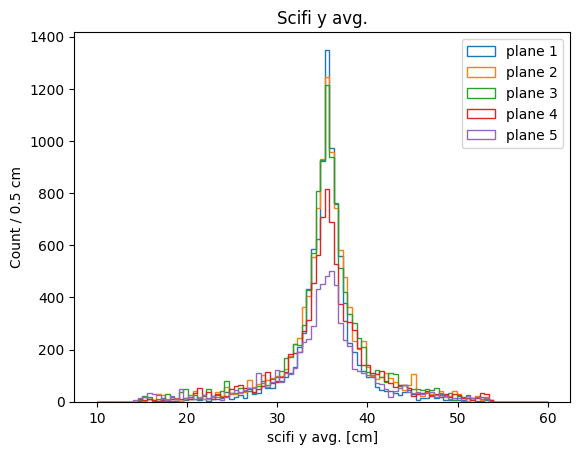

In [8]:
for plane in np.arange(1,6):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    plt.hist(scifi_y_avg[plane_idx][vertical_hits[plane_idx]==0],bins = np.linspace(10,60,100),histtype="step")


plt.xlabel("scifi y avg. [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Scifi y avg.")
plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
# plt.savefig('scifi y avg (overlayed).png')
#     plt.savefig('scifi x avg. (plane {}).png'.format(plane))

plt.show()

In [ ]:
np.savetxt("{}PDF_x_{}.txt".format(options.outputDir,plane), PDF, delimiter=',')

In [ ]:
for i in range(1,6):
    np.loadtxt("{}PDF_x_{}.txt".format(options.outputDir,plane))
    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
    plt.show()

<ipython-input-9-f51ff17352a7>:8: RuntimeWarning: invalid value encountered in divide
  PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)


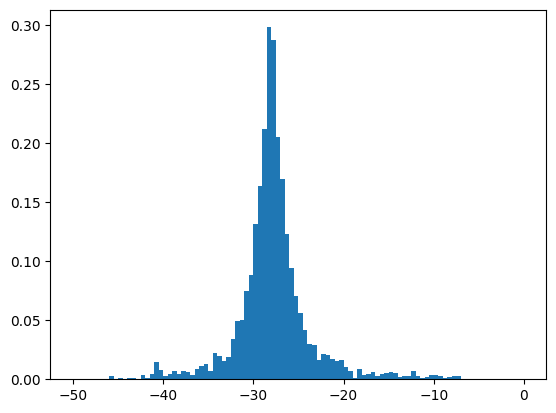

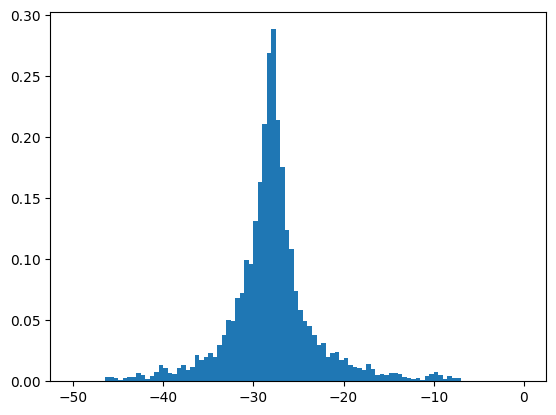

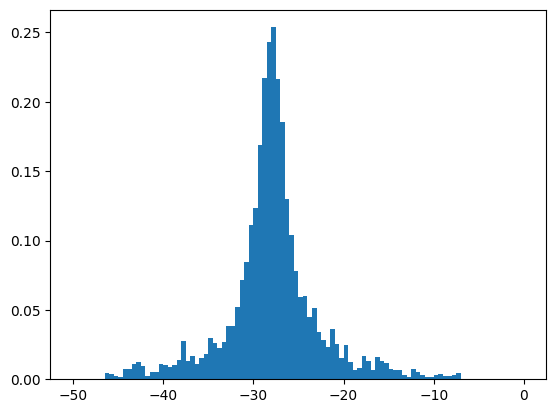

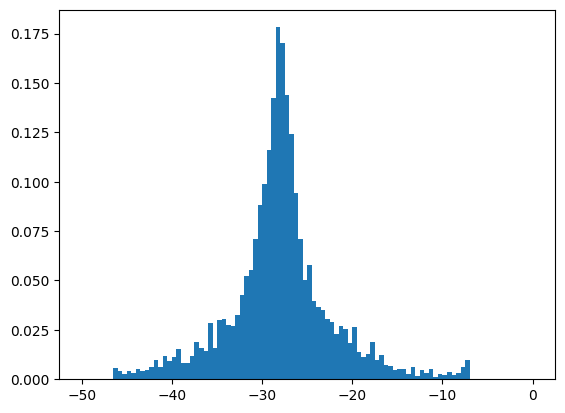

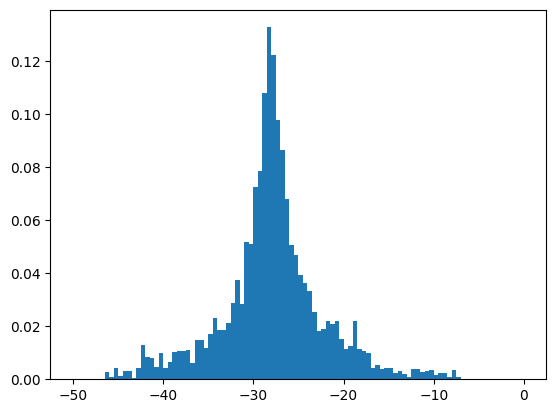

In [9]:
for plane, sipm_counts in enumerate([stat1_x_sipms,stat2_x_sipms,stat3_x_sipms,stat4_x_sipms,stat5_x_sipms],start=1):
    plane_idx = np.where(scifi_plane==plane)[0]
    x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
    stat_x_scaled = np.histogram(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),
                             weights=np.ones(x_size)/(n_files_to_read*10))
    stat_x_sipm_counts = np.histogram(sipm_counts,bins = np.linspace(-50,0,101))

    PDF = np.nan_to_num(stat_x_scaled[0]/stat_x_sipm_counts[0],nan=0.0)

    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
    plt.show()
#     print(PDF)

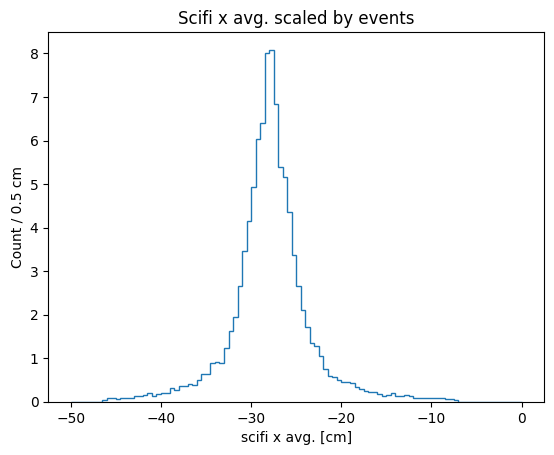

In [16]:
plane_idx = np.where(scifi_plane==1)[0]
x_size = np.shape(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1])[0]
stat1_x_scaled = plt.hist(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,101),histtype="step",
         weights=np.ones(x_size)/1000)

plt.xlabel("scifi x avg. [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Scifi x avg. scaled by events")
# plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
# plt.savefig('scifi x avg (overlayed).png')
#     plt.savefig('scifi x avg. (plane {}).png'.format(plane))

plt.show()

<ipython-input-10-b709bf116c6c>:1: RuntimeWarning: invalid value encountered in divide
  PDF = np.nan_to_num(stat1_x_scaled[0]/stat1_x_sipm_counts[0],nan=0.0)


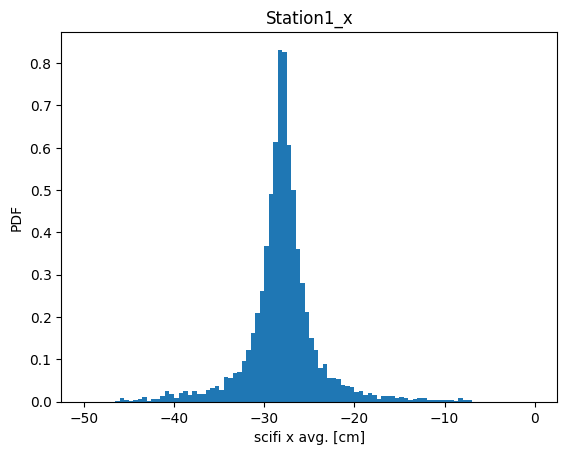

In [10]:
PDF = np.nan_to_num(stat1_x_scaled[0]/stat1_x_sipm_counts[0],nan=0.0)

plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF)
plt.xlabel("scifi x avg. [cm]")
plt.ylabel("PDF")
plt.title("Station1_x")
plt.savefig("scifi x avg. plane 1 pdf.png")
plt.show()

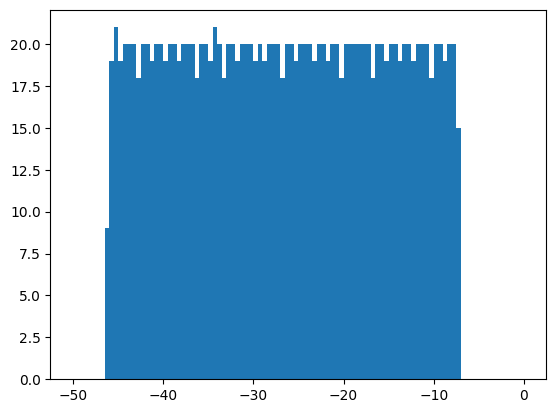

In [11]:
stat1_x_sipm_counts = plt.hist(stat1_x_sipms,bins = np.linspace(-50,0,101))
plt.show()

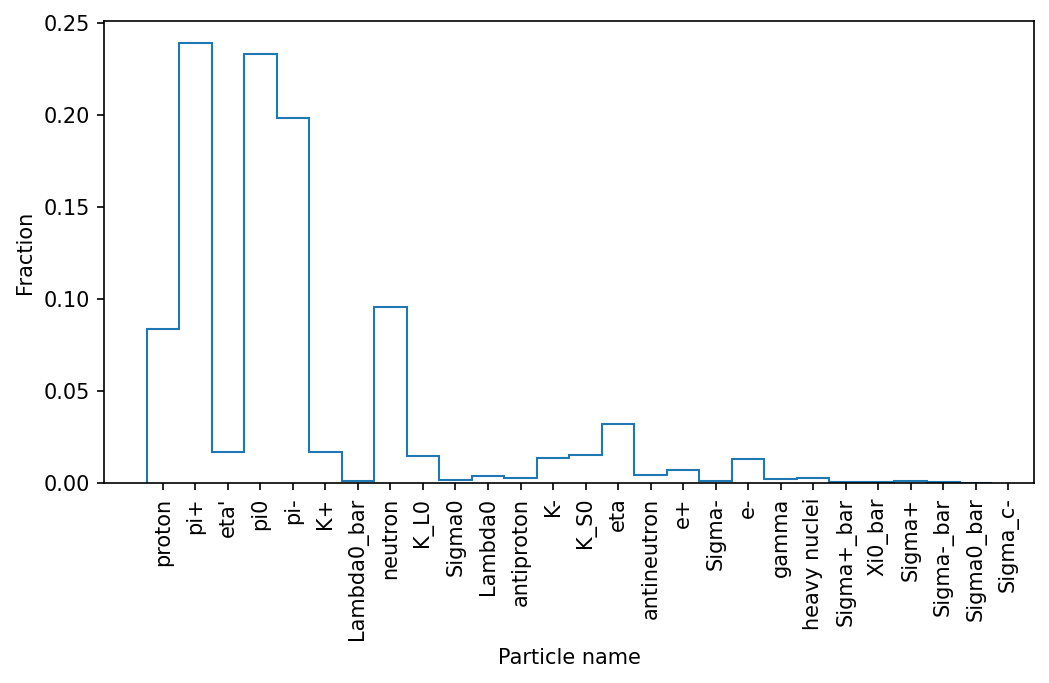

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=150)

plt.hist(particle_name,bins=np.arange(27)-0.5,histtype="step",density=True)
plt.xticks(rotation=90)
plt.xlabel("Particle name")
plt.ylabel("Fraction")
# plt.savefig("Daughter particle abundance (100 GeV).png",bbox_inches = "tight")

plt.show()

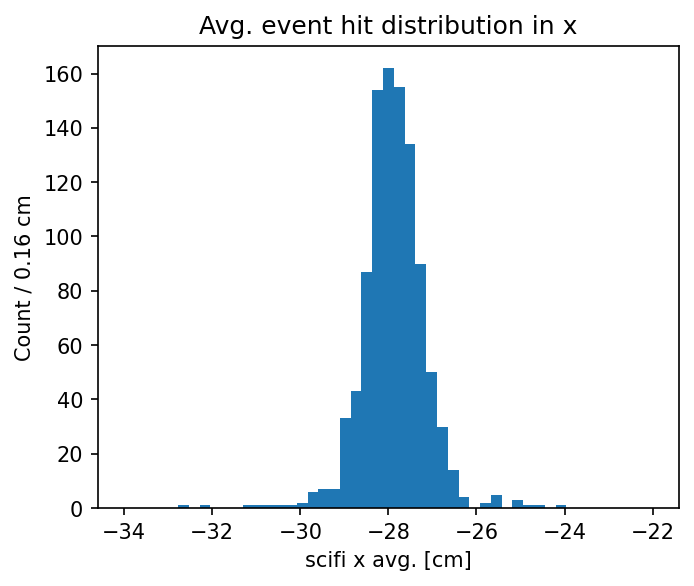

In [9]:
plt.figure(figsize=(5,4),dpi =150)
plt.hist(event_avg_x, bins = np.linspace(-34,-22,50))
plt.xlabel("scifi x avg. [cm]")
plt.ylabel("Count / 0.16 cm")
plt.title("Avg. event hit distribution in x")
# plt.savefig("avg. event hit distribution in x (1000 events, 100 GeV).png")
plt.show()

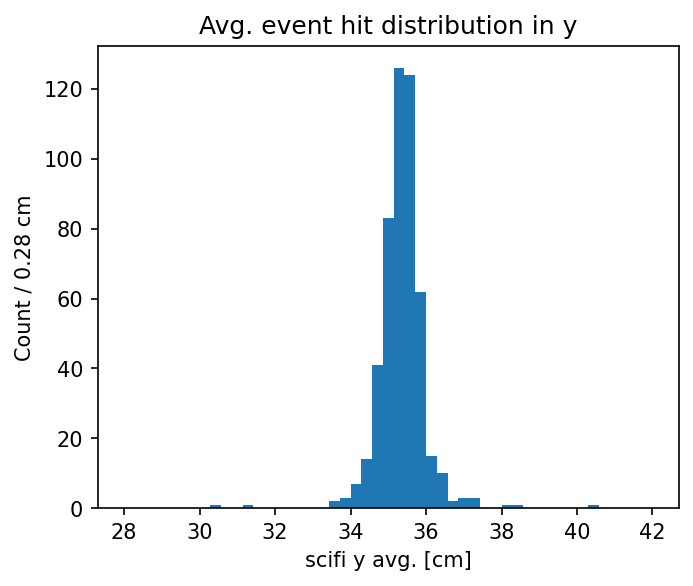

In [9]:
plt.figure(figsize=(5,4),dpi =150)
plt.hist(event_avg_y, bins = np.linspace(28,42,50))
plt.xlabel("scifi y avg. [cm]")
plt.ylabel("Count / 0.28 cm")
plt.title("Avg. event hit distribution in y")
# plt.savefig("avg. event hit distribution in y.png")
# plt.savefig("avg. event hit distribution in y (1000 events, 100 GeV).png")

plt.show()

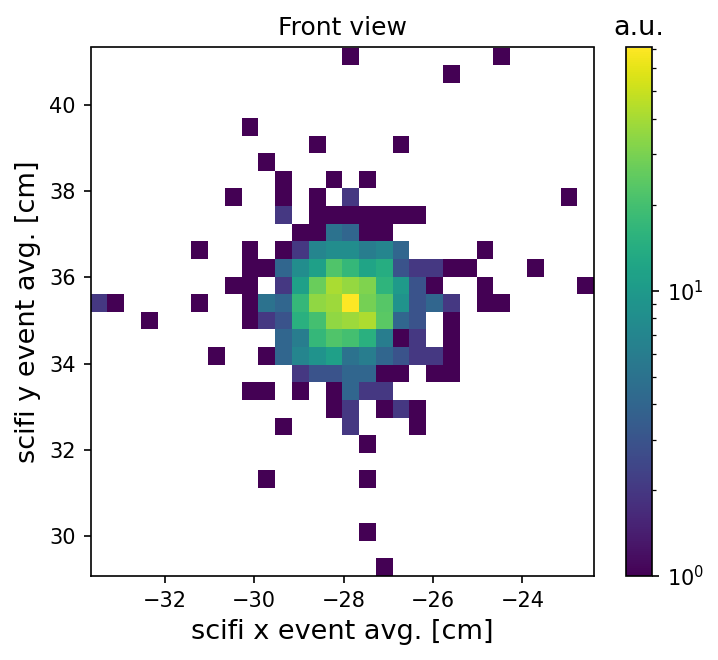

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4.5), dpi=150)
_, _, _, im = ax.hist2d(event_avg_x, event_avg_y, 
                        bins=(30, 30), norm=LogNorm())
                        #, cmap=plt.cm.jet)

plt.xlabel(r'scifi x event avg. [cm]', fontsize=13)
plt.ylabel(r'scifi y event avg. [cm]', fontsize=13)
clb = plt.colorbar(im, ax=ax)
clb.ax.set_title('a.u.', fontsize=13)
plt.title("Front view")
plt.tight_layout()
plt.savefig('scifi front view (avg), 1000 events, 100 GeV.png')

plt.show()

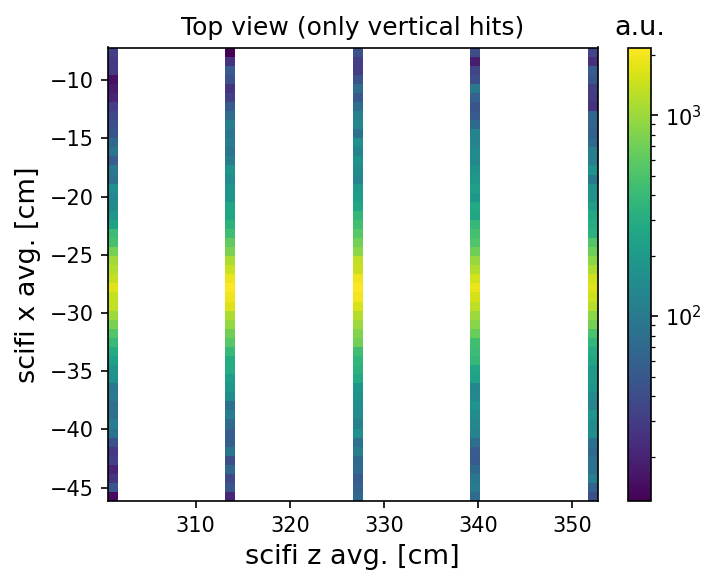

In [9]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
_, _, _, im = ax.hist2d(scifi_z_avg[vertical_hits==1], scifi_x_avg[vertical_hits==1], 
                        bins=(50, 50), norm=LogNorm())
                        #, cmap=plt.cm.jet)

plt.xlabel(r'scifi z avg. [cm]', fontsize=13)
plt.ylabel(r'scifi x avg. [cm]', fontsize=13)
clb = plt.colorbar(im, ax=ax)
clb.ax.set_title('a.u.', fontsize=13)
plt.title("Top view (only vertical hits)")
plt.tight_layout()
# plt.savefig('scifi top view (only vertical hits).png')

plt.show()

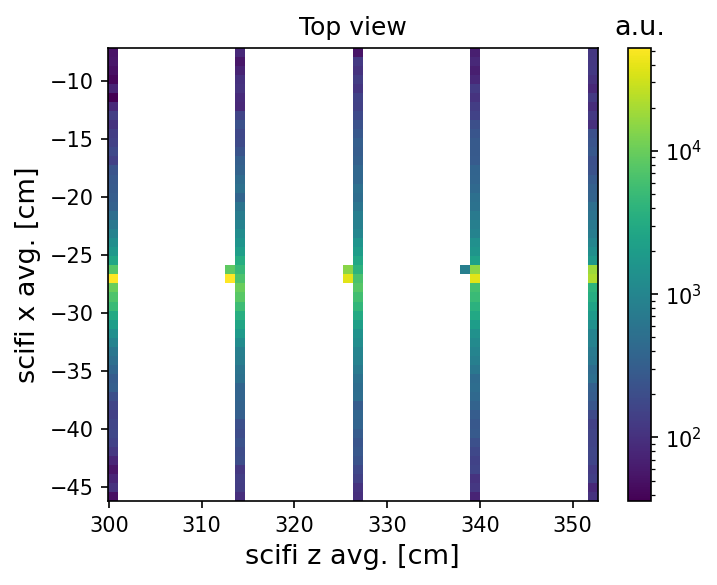

In [12]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
_, _, _, im = ax.hist2d(scifi_z_avg, scifi_x_avg, 
                        bins=(50, 50), norm=LogNorm())
                        #, cmap=plt.cm.jet)

plt.xlabel(r'scifi z avg. [cm]', fontsize=13)
plt.ylabel(r'scifi x avg. [cm]', fontsize=13)
clb = plt.colorbar(im, ax=ax)
clb.ax.set_title('a.u.', fontsize=13)
plt.title("Top view")
plt.tight_layout()
# plt.savefig('scifi top view.png')

plt.show()

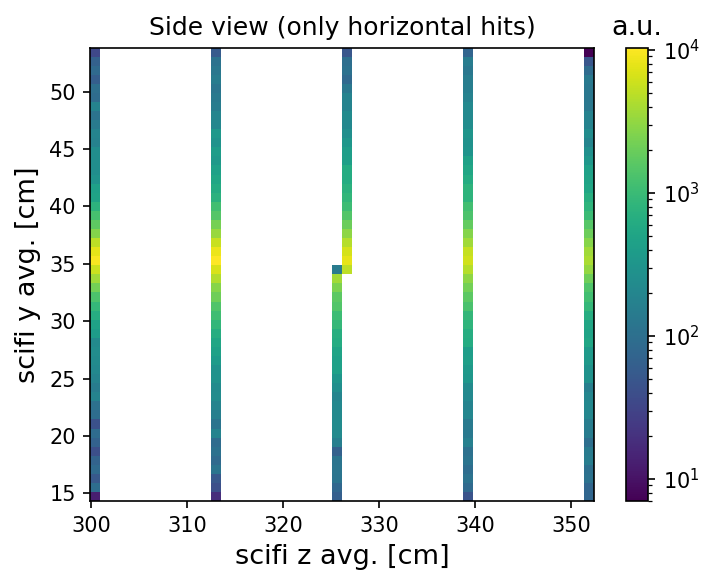

In [10]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
_, _, _, im = ax.hist2d(scifi_z_avg[vertical_hits==0], scifi_y_avg[vertical_hits==0], 
                        bins=(50, 50), norm=LogNorm())
                        #, cmap=plt.cm.jet)

plt.xlabel(r'scifi z avg. [cm]', fontsize=13)
plt.ylabel(r'scifi y avg. [cm]', fontsize=13)
clb = plt.colorbar(im, ax=ax)
clb.ax.set_title('a.u.', fontsize=13)
plt.title("Side view (only horizontal hits)")
plt.tight_layout()
plt.savefig('scifi side view (only horizontal hits).png')

plt.show()

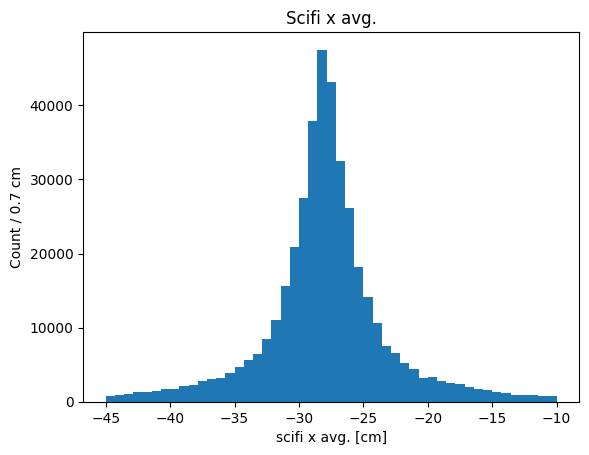

In [11]:
plt.hist(scifi_x_avg[vertical_hits==1],bins = np.linspace(-45,-10,50))
plt.xlabel("scifi x avg. [cm]")
plt.ylabel("Count / 0.7 cm")
plt.title("Scifi x avg.")
# plt.savefig('scifi x avg.png')

plt.show()

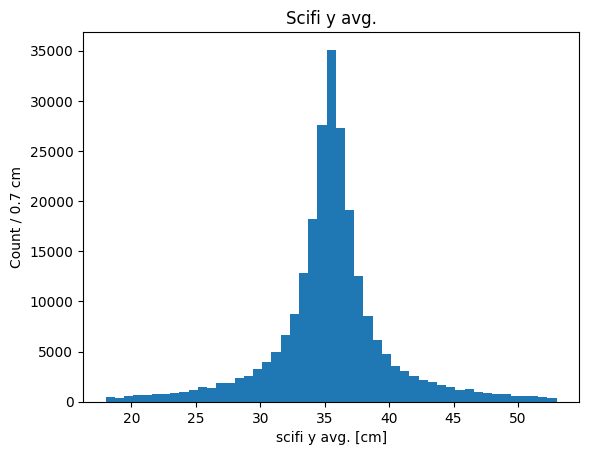

In [23]:
plt.hist(scifi_y_avg[vertical_hits==0],bins = np.linspace(18,53,50))
plt.xlabel("scifi y avg. [cm]")
plt.ylabel("Count / 0.7 cm")
plt.title("Scifi y avg.")
plt.savefig('scifi y avg.png')

plt.show()

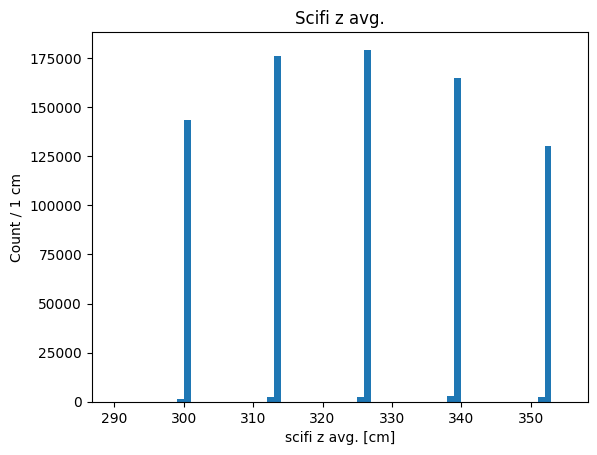

In [12]:
plt.hist(scifi_z_avg,bins = np.linspace(290,355,66))
plt.xlabel("scifi z avg. [cm]")
plt.ylabel("Count / 1 cm")
plt.title("Scifi z avg.")
# plt.savefig('scifi z avg.png')

plt.show()

In [ ]:
plt.hist(pi_px,bins = 50)
plt.xlabel("Px")
plt.ylabel("Count")
plt.title("Px of pion mother particle")
plt.show()

In [ ]:
for plane in np.arange(1,6):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
    _, _, _, im = ax.hist2d(scifi_x_avg[plane_idx], scifi_y_avg[plane_idx], 
                            bins=(np.linspace(-55,0,50), np.linspace(0,55,50)), norm=LogNorm())
                            #, cmap=plt.cm.jet)

    plt.xlabel(r'scifi x avg. [cm]', fontsize=13)
    plt.ylabel(r'scifi y avg. [cm]', fontsize=13)
    clb = plt.colorbar(im, ax=ax)
    clb.ax.set_title('a.u.', fontsize=13)
    plt.title("Front view (plane {})".format(plane))
    plt.tight_layout()
#     plt.savefig('scifi front view (plane {}).png'.format(plane))

    plt.show()

In [ ]:
a, b = r.TVector3(), r.TVector3()
        h_hor = r.TH2D('h_hor', 'h_hor;z;y', 500, 280, 380, 120, 0, 60)
        h_ver = r.TH2D('h_ver', 'h_ver;z;x', 500, 280, 380, 100, -50, 0)
        h_

        for i_sta in range(1,6):
            for i_mat in range(0,3):
                for i_sipm in range(0,4):
                    for i_chan in range(0, 128):

                        id = i_sta*1000000 + i_mat*10000 + i_sipm*1000 + i_chan

                        # Horizontal
                        scifiDet.GetSiPMPosition(id, a, b);
                        h_hor.Fill((a.Z() + b.Z())/2., (a.Y() + b.Y())/2.)

                        # Vertical
                        id += 100000 
                        scifiDet.GetSiPMPosition(id, a, b)
                        h_ver.Fill((a.Z() + b.Z())/2., (a.X() + b.X())/2.)

        c1 = r.TCanvas('c1', '', 800, 800)
        h_hor.Draw('COLZ')
        c1.Draw()
        c1.SaveAs('./zy.pdf')

        c2 = r.TCanvas('c2', '', 800, 800)
        h_ver.Draw('COLZ')
        c2.Draw()
        c2.SaveAs('./zx.pdf')

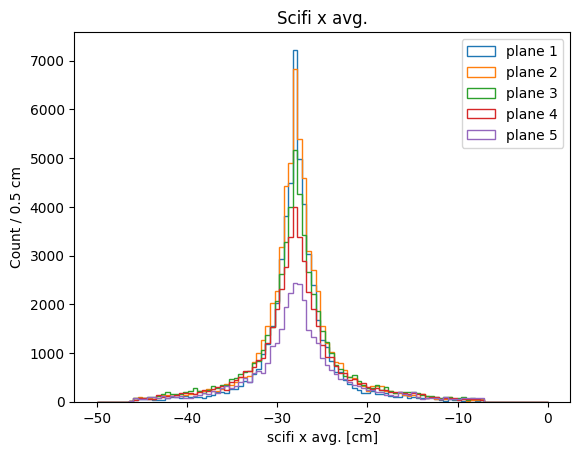

In [12]:
for plane in np.arange(1,6):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    plt.hist(scifi_x_avg[plane_idx][vertical_hits[plane_idx]==1],bins = np.linspace(-50,-0,100),histtype="step")

plt.xlabel("scifi x avg. [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Scifi x avg.")
plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
plt.savefig('scifi x avg (overlayed).png')
#     plt.savefig('scifi x avg. (plane {}).png'.format(plane))

plt.show()

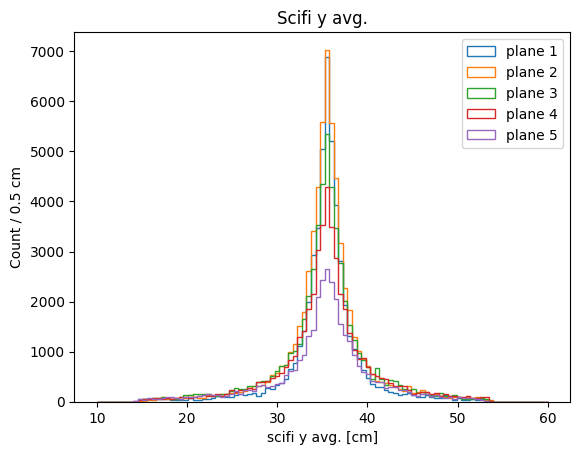

In [13]:
for plane in np.arange(1,6):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    plt.hist(scifi_y_avg[plane_idx][vertical_hits[plane_idx]==0],bins = np.linspace(10,60,100),histtype="step")


plt.xlabel("scifi y avg. [cm]")
plt.ylabel("Count / 0.5 cm")
plt.title("Scifi y avg.")
plt.legend(["plane 1","plane 2","plane 3","plane 4","plane 5"])
plt.savefig('scifi y avg (overlayed).png')
#     plt.savefig('scifi x avg. (plane {}).png'.format(plane))

plt.show()

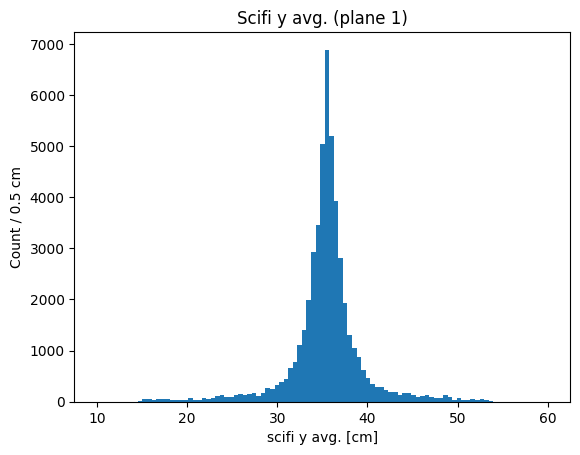

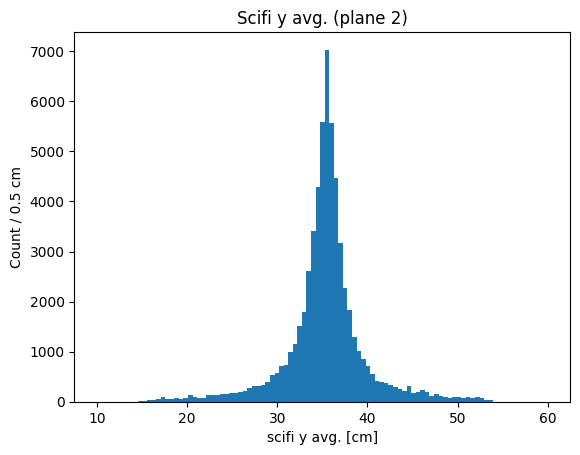

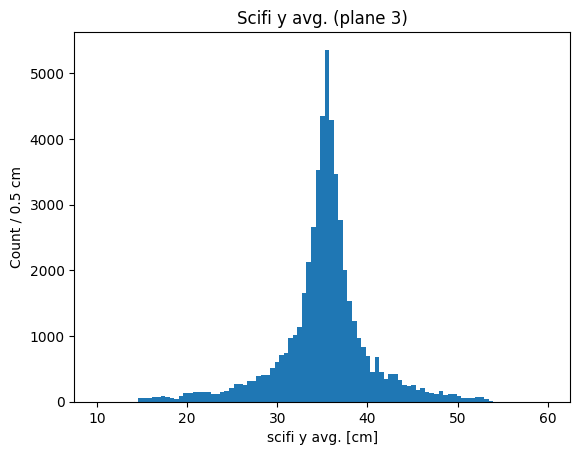

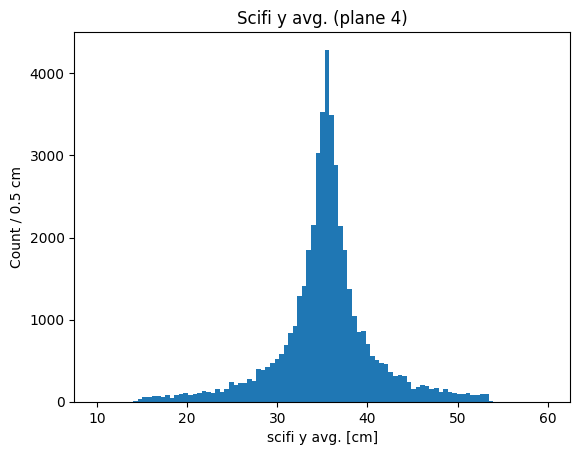

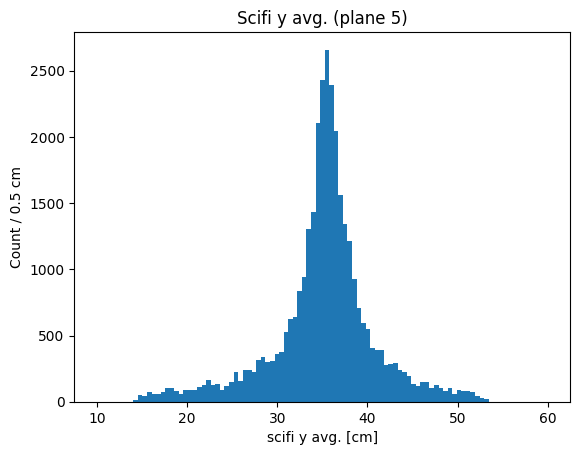

In [75]:
for plane in np.arange(1,6):
    plane_idx = np.where(scifi_plane==plane)[0]
    
    plt.hist(scifi_y_avg[plane_idx][vertical_hits[plane_idx]==0],bins = np.linspace(10,60,100))
    plt.xlabel("scifi y avg. [cm]")
    plt.ylabel("Count / 0.5 cm")
    plt.title("Scifi y avg. (plane {})".format(plane))
#     plt.savefig('scifi x avg.png')
    plt.savefig('scifi y avg. (plane {}).png'.format(plane))

    plt.show()